# Figures for the paper

In [31]:
from viz import get_result_dfs

exps = [("A", "A"), ("A", "B"), ("B", "B"), ("B", "A")]
# exps = [("A", "AH"), ("AE", "AH"), ("A", "BH"), ("AE", "BH")]
# exps = [("all", "BH"), ("AE", "BH")]
metric = "auroc"
reporter = "lr"
rs = dict()
for i, (fr, to) in enumerate(exps):
    avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(fr, to, label_col="alice_label", filter_by="disagree", metric=metric, reporter=reporter)
    rs[(fr, to)] = (avg_reporter_results, result_dfs, avg_lm_result, lm_results)

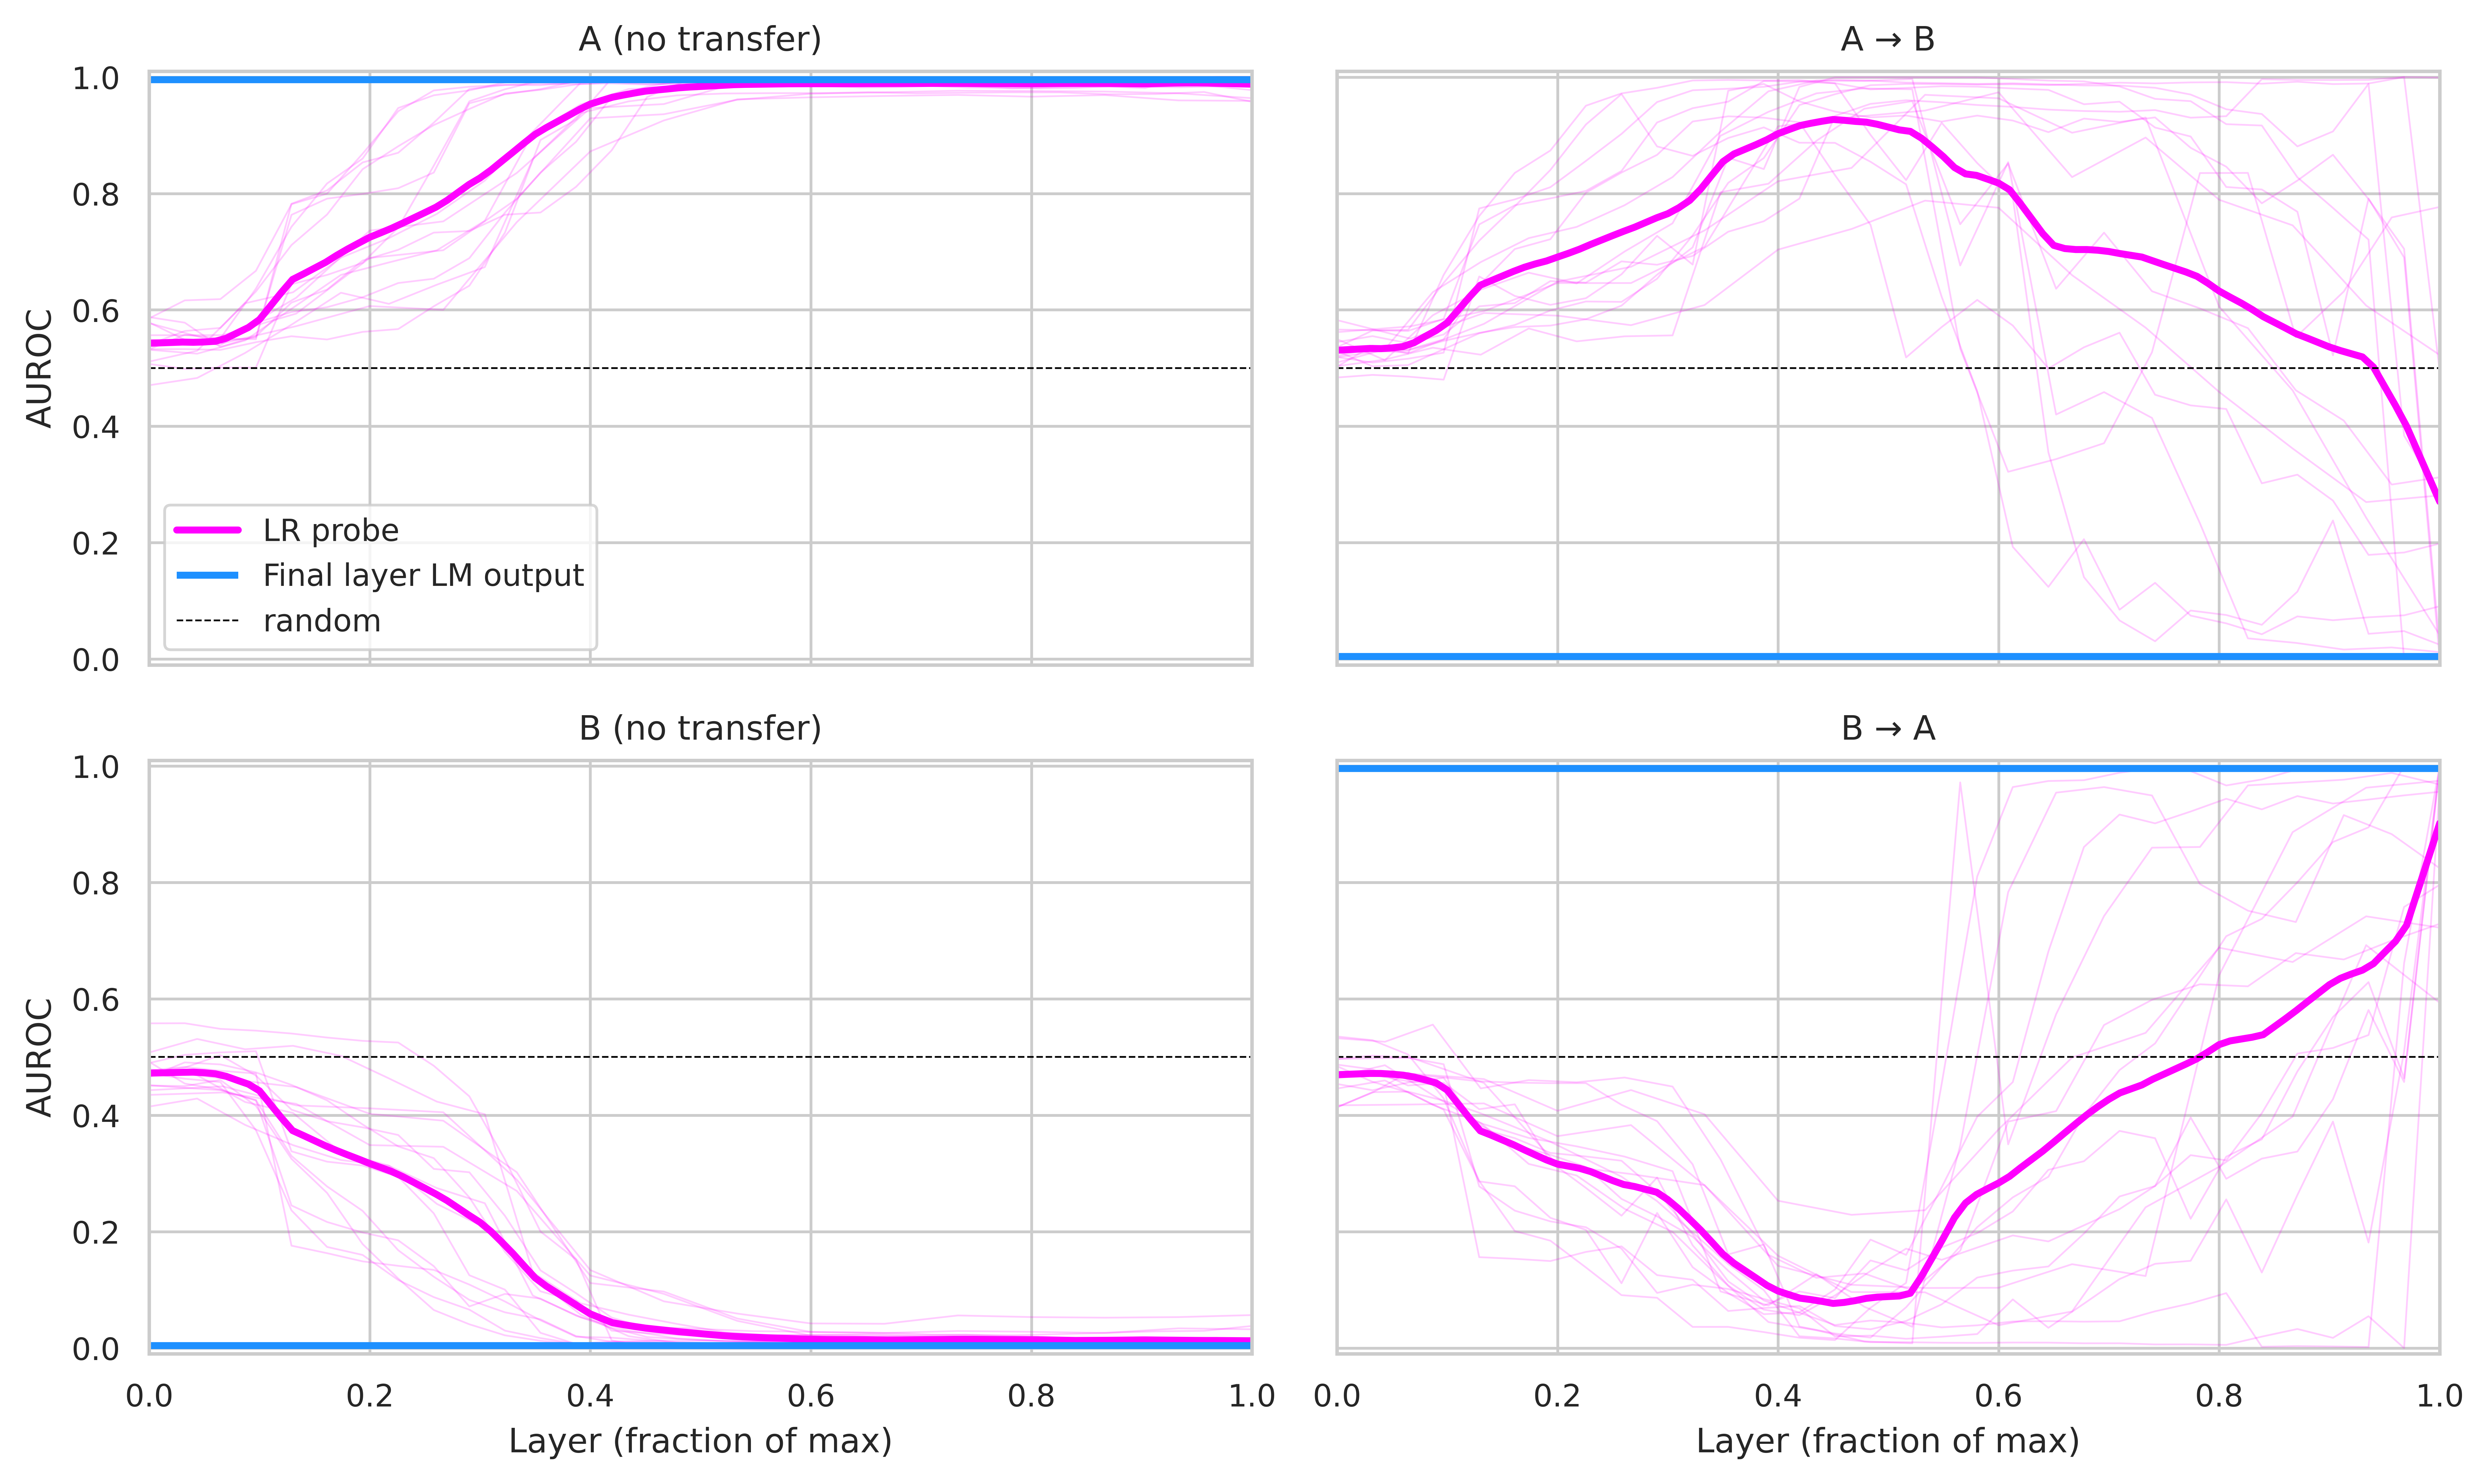

In [33]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

import matplotlib.colors as mcolors

named_colors = list(mcolors.CSS4_COLORS.keys())[20:]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6), dpi=800)

for i, (fr, to) in enumerate(exps):
    ax = axes[i // 2][i % 2]
    avg_reporter_results, results_dfs, avg_lm_result, lm_results = rs[(fr, to)]
    j = 0
    for key, result_df, lm_result in zip(results_dfs.keys(), results_dfs.values(), lm_results.values()):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.2, color="fuchsia", linewidth=0.5)
        # ax.hlines(lm_result, 0, 1, alpha=1, color=named_colors[j], linewidth=1, label=str(key))
        # ax.hlines(result_df["lm_auroc"].iloc[0], 0, 1, alpha=0.2, color="dodgerblue", linewidth=0.5)
        j += 1

    ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], label="LR probe", linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_result, 0, 1, label="Final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 2 == 0:
        ax.set_ylabel("AUROC")
    if i // 2 == 1: 
        ax.set_xlabel("Layer (fraction of max)")
    if fr == to:
        title = fr.title() + " (no transfer)"
    else:
        title = (f"{fr} → {to}")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 0:
        ax.legend()

plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig("../../figures/layerwise_auroc_AB.pdf")
plt.show()

# Table of results for LR and CCS

In [30]:
import numpy as np

exps = [("all", "BH"), ("AE", "BH")]
for i, (fr, to) in enumerate(exps):
    avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(fr, to, filter_by="disagree", label_col="alice_label", reporter="ccs")
    print(f"Average disagreeing AUROC for {fr} → {to}: {avg_reporter_results['auroc'].mean():.3f} +/- {2 * avg_reporter_results['auroc'].std() / np.sqrt(len(avg_reporter_results)):.3f}")

print("Logistic regression:")

exps = [("AE", "BH")]
for i, (fr, to) in enumerate(exps):
    avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(fr, to, filter_by="disagree", label_col="alice_label", reporter="lr")
    print(f"Average disagreeing AUROC for {fr} → {to}: {avg_reporter_results['auroc'].mean():.3f} +/- {2 * avg_reporter_results['auroc'].std() / np.sqrt(len(avg_reporter_results)):.3f}")

Average disagreeing AUROC for all → BH: 0.507 +/- 0.002
Average disagreeing AUROC for AE → BH: 0.610 +/- 0.018
Logistic regression:
Average disagreeing AUROC for AE → BH: 0.615 +/- 0.024
